# TROPOMI S5P CH4 Level 2 - Multi-File AOI Processing, Gridding, and Visualization

## About

This notebook loads data from multiple TROPOMI S5P Level 2 CH4 (NetCDF4/HDF5) files, processes them for a user-defined Area of Interest (AOI), and performs the following:
1. Extracts latitude, longitude, UTC time, QA value, and methane data (e.g., methane_mixing_ratio_bias_corrected) from the `/PRODUCT` group.
2. Filters the data for the specified AOI and `qa_value > 0.5` (or other recommended threshold).
3. Visualizes a combined map of the filtered methane data.
4. Saves two ASCII (CSV) files:
    a. All individual good-quality pixel data (datetime, lat, lon, CH4, QA) within the AOI.
    b. Gridded mean methane values (in original units) within the AOI.

## Step 1: Load Python Libraries

In [1]:
import xarray as xr 
import numpy as np      
import os                    
import datetime              
import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## Step 2: User Settings, AOI Definition, and File Discovery

In [2]:
# --- User Settings --- #
data_dir_tropomi_ch4 = '../data/tropomi_ch4/' # Adjust if your path is different
tropomi_ch4_file_pattern = os.path.join(data_dir_tropomi_ch4, "S5P_OFFL_L2__CH4____*.nc") 

output_image_dir = '../output/images/' 
output_ascii_dir = '../output/ascii/'   

# Define your Area of Interest (AOI)
lat_min_aoi = 7.0   
lat_max_aoi = 23.0
lon_min_aoi = 95.0
lon_max_aoi = 110.0

# Define grid resolution for mean CH4 calculation (in degrees)
grid_resolution = 0.1 # e.g., 0.1 means 0.1x0.1 degree grid cells

# Variable paths within the NetCDF file (typically under /PRODUCT group for TROPOMI L2 CH4)
lat_var_path = '/PRODUCT/latitude'
lon_var_path = '/PRODUCT/longitude'
ch4_var_path = '/PRODUCT/methane_mixing_ratio_bias_corrected' # Or 'methane_mixing_ratio'
qa_var_path = '/PRODUCT/qa_value'
time_utc_var_path = '/PRODUCT/time_utc' # This is 1D (scanline) in PRODUCT group for CH4
# --- End User Settings --- #

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_ascii_dir, exist_ok=True)

tropomi_ch4_file_list = sorted(glob.glob(tropomi_ch4_file_pattern))

base_output_filename_prefix = "TROPOMI_CH4_Combined" # Default for multi-file output

if not tropomi_ch4_file_list:
    print(f"No TROPOMI CH4 NetCDF files found in {data_dir_tropomi_ch4} matching pattern '{tropomi_ch4_file_pattern}'.")
else:
    print(f"Found {len(tropomi_ch4_file_list)} TROPOMI CH4 files to process:")
    for f_name in tropomi_ch4_file_list:
        print(f"- {f_name}")

Found 1 TROPOMI CH4 files to process:
- ../data/tropomi_ch4/S5P_OFFL_L2__CH4____20240321T061037_20240321T075208_33353_03_020600_20240323T160422.nc


## Step 3: Load Data, Process, Clip to AOI, and Aggregate

In [3]:
# Lists to store data for combined plotting
latitude_all_granules_plot = [] 
longitude_all_granules_plot = [] 
ch4_for_plot_all_granules = [] 

# Lists for the ASCII pixel data file
ascii_pixels_datetime = []
ascii_pixels_lat = []
ascii_pixels_lon = []
ascii_pixels_ch4 = []
ascii_pixels_qa = []

# Lists for data to be gridded
lat_for_gridding_ch4 = []
lon_for_gridding_ch4 = []
ch4_for_gridding = [] 

var_attributes = {}
any_file_processed_successfully = False

if tropomi_ch4_file_list: 
    for i_file, file_path in enumerate(tropomi_ch4_file_list):
        print(f"\n--- Processing file: {os.path.basename(file_path)} ---")
        ds_product = None # Initialize
        try:
            ds_product = xr.open_dataset(file_path, engine='h5netcdf', group='PRODUCT')
            print(f"  Successfully opened file and accessed /PRODUCT group: {os.path.basename(file_path)}")
            
            latitude_granule_raw = ds_product['latitude'].data[0,:,:] 
            longitude_granule_raw = ds_product['longitude'].data[0,:,:]
            ch4_raw_granule = ds_product[ch4_var_path.split('/')[-1]].data[0,:,:] 
            qa_raw_granule = ds_product['qa_value'].data[0,:,:]
            time_utc_raw_1d = ds_product['time_utc'].data[0,:] 

            if i_file == 0 or not var_attributes: 
                var_attributes['CH4_long_name'] = ds_product[ch4_var_path.split('/')[-1]].attrs.get('long_name', 'Methane Mixing Ratio')
                var_attributes['CH4_units'] = ds_product[ch4_var_path.split('/')[-1]].attrs.get('units', 'ppb')
                var_attributes['CH4_fill_value'] = ds_product[ch4_var_path.split('/')[-1]].attrs.get('_FillValue', np.nan) 
                var_attributes['QA_fill_value'] = ds_product['qa_value'].attrs.get('_FillValue', 255) 
                var_attributes['QA_scale_factor'] = ds_product['qa_value'].attrs.get('scale_factor', 1.0)
                var_attributes['QA_add_offset'] = ds_product['qa_value'].attrs.get('add_offset', 0.0)
                var_attributes['Lat_fill_value'] = ds_product['latitude'].attrs.get('_FillValue', np.nan)
                var_attributes['Lon_fill_value'] = ds_product['longitude'].attrs.get('_FillValue', np.nan)

            qa_fill_val = var_attributes['QA_fill_value']
            qa_processed_granule = np.where(qa_raw_granule == qa_fill_val, np.nan, qa_raw_granule.astype(float) * var_attributes['QA_scale_factor'] + var_attributes['QA_add_offset'])

            ch4_fill_val = var_attributes['CH4_fill_value']
            ch4_processed_granule = np.where(ch4_raw_granule == ch4_fill_val, np.nan, ch4_raw_granule) 
            
            lat_granule_plot = np.where(latitude_granule_raw == var_attributes['Lat_fill_value'], np.nan, latitude_granule_raw)
            lon_granule_plot = np.where(longitude_granule_raw == var_attributes['Lon_fill_value'], np.nan, longitude_granule_raw)

            aoi_mask = (~np.isnan(lat_granule_plot)) & (~np.isnan(lon_granule_plot)) & \
                         (lat_granule_plot >= lat_min_aoi) & (lat_granule_plot <= lat_max_aoi) & \
                         (lon_granule_plot >= lon_min_aoi) & (lon_granule_plot <= lon_max_aoi)
            good_qa_mask = qa_processed_granule > 0.5 
            final_valid_mask = aoi_mask & good_qa_mask

            ch4_plot_granule = np.where(final_valid_mask, ch4_processed_granule, np.nan)
            
            latitude_all_granules_plot.append(lat_granule_plot)
            longitude_all_granules_plot.append(lon_granule_plot)
            ch4_for_plot_all_granules.append(ch4_plot_granule)

            if np.any(final_valid_mask):
                any_file_processed_successfully = True

            time_utc_pixel_granule = np.empty_like(latitude_granule_raw, dtype=object)
            for i_scan in range(latitude_granule_raw.shape[0]): 
                time_utc_pixel_granule[i_scan, :] = time_utc_raw_1d[i_scan]

            lats_to_save = lat_granule_plot[final_valid_mask]
            lons_to_save = lon_granule_plot[final_valid_mask]
            ch4_to_save = ch4_processed_granule[final_valid_mask]
            qa_to_save = qa_processed_granule[final_valid_mask]
            time_str_to_save = time_utc_pixel_granule[final_valid_mask]
            
            for idx_save in range(len(lats_to_save)):
                current_time_str = time_str_to_save[idx_save]
                dt_obj = None
                try:
                    dt_obj = datetime.datetime.strptime(current_time_str.decode('utf-8') if isinstance(current_time_str, bytes) else current_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
                    dt_obj = dt_obj.replace(tzinfo=datetime.timezone.utc)
                except ValueError:
                    dt_obj = None
                
                if dt_obj is not None:
                    ascii_pixels_datetime.append(dt_obj)
                    ascii_pixels_lat.append(lats_to_save[idx_save])
                    ascii_pixels_lon.append(lons_to_save[idx_save])
                    ascii_pixels_ch4.append(ch4_to_save[idx_save])
                    ascii_pixels_qa.append(qa_to_save[idx_save] if not np.isnan(qa_to_save[idx_save]) else -1.0)
                    
                    lat_for_gridding_ch4.append(lats_to_save[idx_save])
                    lon_for_gridding_ch4.append(lons_to_save[idx_save])
                    ch4_for_gridding.append(ch4_to_save[idx_save])
        
            print(f"  Data from {os.path.basename(file_path)} processed and AOI/QA filtered pixels collected.")

        except Exception as e:
            print(f"  Error processing file {file_path}: {e}")
            if ds_product is None:
                 try:
                     with xr.open_dataset(file_path, engine='h5netcdf', decode_cf=False) as ds_debug_root:
                         print(f"    Available groups at root: {list(ds_debug_root.groups)}")
                         for group_name in ds_debug_root.groups:
                             with xr.open_dataset(file_path, engine='h5netcdf', group=group_name, decode_cf=False) as ds_debug_group:
                                 print(f"    Variables in group '{group_name}': {list(ds_debug_group.variables.keys())}")
                 except Exception as e_debug_root:
                     print(f"    Could not further inspect file {file_path}: {e_debug_root}")
            continue 
        finally:
            if ds_product:
                ds_product.close()
                print(f"  NetCDF file {os.path.basename(file_path)} has been closed.")
    
    # Determine base_output_filename_prefix for output files
    if not any_file_processed_successfully:
        print("No data was successfully processed from any files within the AOI and QA criteria.")
        base_output_filename_prefix = "TROPOMI_CH4_Combined_NoData_In_AOI" # Specific name if no data found
    else:
        print(f"\nFinished processing all {len(tropomi_ch4_file_list)} files.")
        # Always use "TROPOMI_CH4_Combined_AOI" if any file was processed successfully
        base_output_filename_prefix = "TROPOMI_CH4_Combined_AOI"
    
    print("Data loading and initial processing complete.")
else:
    print("File list is empty. Nothing to process.")


--- Processing file: S5P_OFFL_L2__CH4____20240321T061037_20240321T075208_33353_03_020600_20240323T160422.nc ---
  Successfully opened file and accessed /PRODUCT group: S5P_OFFL_L2__CH4____20240321T061037_20240321T075208_33353_03_020600_20240323T160422.nc
  Data from S5P_OFFL_L2__CH4____20240321T061037_20240321T075208_33353_03_020600_20240323T160422.nc processed and AOI/QA filtered pixels collected.
  NetCDF file S5P_OFFL_L2__CH4____20240321T061037_20240321T075208_33353_03_020600_20240323T160422.nc has been closed.

Finished processing all 1 files.
Data loading and initial processing complete.


## Step 4: Define Map Extent (Based on AOI for Plotting)

In [4]:
map_extent_aoi_plot = None
if any_file_processed_successfully: 
    padding = 2.0 
    map_extent_aoi_plot = [lon_min_aoi - padding, lon_max_aoi + padding, 
                           lat_min_aoi - padding, lat_max_aoi + padding]
    print(f"Map extent for AOI plotting (with padding): {map_extent_aoi_plot}")
else:
    print("Cannot define map extent as no data was loaded.")

Map extent for AOI plotting (with padding): [93.0, 112.0, 5.0, 25.0]


## Step 5: Visualize and Save Combined & Clipped Methane Map
Data is filtered for `qa_value > 0.5` and shown for the AOI.

Methane Map saved to: ../output/images/TROPOMI_CH4_Combined_AOI_CH4_QA05.png


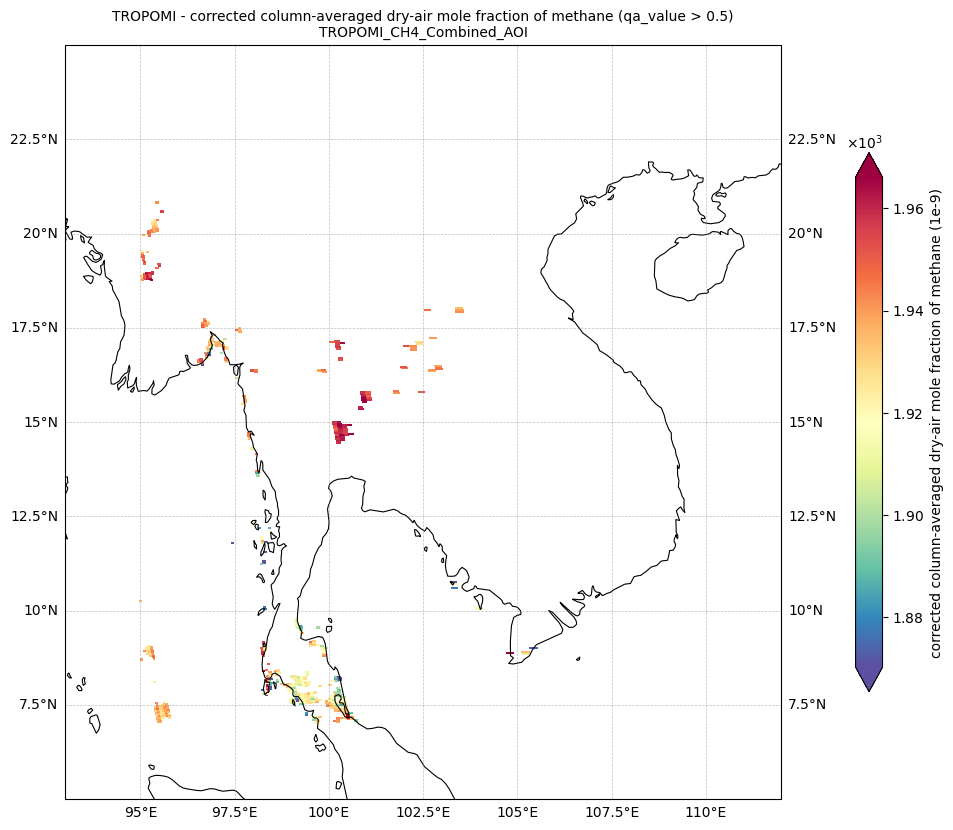

In [5]:
if any_file_processed_successfully and map_extent_aoi_plot is not None and ch4_for_plot_all_granules:
    extent_padding_val = 1.0
    
    fig = plt.figure(figsize=(12, 10)) 
    ax = plt.axes(projection=ccrs.PlateCarree())
    try:
        ax.set_extent(map_extent_aoi_plot, crs=ccrs.PlateCarree())
    except Exception as e:
        print(f"Error setting map extent {map_extent_aoi_plot}: {e}. Attempting broader extent.")
        if longitude_all_granules_plot and latitude_all_granules_plot:
            all_lons_flat = np.concatenate([lon.ravel() for lon in longitude_all_granules_plot if lon.size > 0 and np.any(~np.isnan(lon))])
            all_lats_flat = np.concatenate([lat.ravel() for lat in latitude_all_granules_plot if lat.size > 0 and np.any(~np.isnan(lat))])
            if all_lons_flat.size > 0 and all_lats_flat.size > 0:
                ax.set_extent([np.nanmin(all_lons_flat)-extent_padding_val, np.nanmax(all_lons_flat)+extent_padding_val, 
                                np.nanmin(all_lats_flat)-extent_padding_val, np.nanmax(all_lats_flat)+extent_padding_val], 
                               crs=ccrs.PlateCarree())
            else:
                ax.set_global()
        else:
            ax.set_global()
    
    ax.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False; gl.right_labels = True 
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    
    plotted_mesh_ch4 = None
    all_valid_ch4_for_scaling = []
    for i in range(len(longitude_all_granules_plot)):
        ch4_g = ch4_for_plot_all_granules[i]
        if ch4_g.size > 0 and np.any(~np.isnan(ch4_g)):
            all_valid_ch4_for_scaling.extend(ch4_g[~np.isnan(ch4_g)].flatten())
            
    if all_valid_ch4_for_scaling:
        vmin_plot = np.percentile(all_valid_ch4_for_scaling, 2) 
        vmax_plot = np.percentile(all_valid_ch4_for_scaling, 98) 
        # vmin_plot = 1700 # Example fixed range for CH4 in ppb
        # vmax_plot = 2200
        if vmax_plot <= vmin_plot: vmax_plot = vmin_plot + 50 
    else:
        vmin_plot = 1700; vmax_plot = 2200 

    for i in range(len(longitude_all_granules_plot)):
        lon_g = longitude_all_granules_plot[i]
        lat_g = latitude_all_granules_plot[i]
        ch4_g = ch4_for_plot_all_granules[i]
        if ch4_g.size > 0 and np.any(~np.isnan(ch4_g)):
            mesh = ax.pcolormesh(lon_g, lat_g, ch4_g, 
                                 transform=ccrs.PlateCarree(), cmap='Spectral_r', 
                                 vmin=vmin_plot, vmax=vmax_plot, shading='auto')
            if plotted_mesh_ch4 is None: plotted_mesh_ch4 = mesh 
    
    ch4_display_long_name = var_attributes.get('CH4_long_name', 'Methane')
    ch4_display_units = var_attributes.get('CH4_units', 'ppb')
    title_str_prefix = f'TROPOMI - {ch4_display_long_name} (qa_value > 0.5)'
    title_str_suffix = base_output_filename_prefix # Use the globally set prefix

    if plotted_mesh_ch4 is not None:
        cbar = plt.colorbar(plotted_mesh_ch4, ax=ax, orientation='vertical', pad=0.08, shrink=0.7, extend='both')
        cbar.set_label(f"{ch4_display_long_name} ({ch4_display_units})")
        cbar.formatter = mticker.ScalarFormatter(useMathText=True) # Use scientific for CH4 units if large
        cbar.formatter.set_powerlimits((0, 0))
        cbar.update_ticks()
        plt.title(f'{title_str_prefix}\n{title_str_suffix}', fontsize=10)
    else:
        print("No valid CH4 data to plot after QA filtering.")
        plt.title(f'{title_str_prefix}\nNo valid data in AOI from loaded files', fontsize=10)
    
    save_filename_ch4 = f"{base_output_filename_prefix}_CH4_QA05.png"
    full_save_path_ch4 = os.path.join(output_image_dir, save_filename_ch4)
    plt.savefig(full_save_path_ch4, dpi=300, bbox_inches='tight') 
    print(f"Methane Map saved to: {full_save_path_ch4}")
    plt.show() 
    plt.close(fig)
else:
    print("Skipping CH4 map plotting: Data not loaded/processed, map extent not calculated, or no plottable CH4 data.")

## Step 6: Create Gridded Mean Methane for AOI

In [6]:
gridded_mean_ch4_for_ascii = [] 

if any_file_processed_successfully and lat_for_gridding_ch4 and map_extent_aoi_plot is not None:
    print(f"\nCalculating gridded mean Methane for AOI with {grid_resolution}-degree resolution...")
    np_lat_ch4_grid = np.array(lat_for_gridding_ch4)
    np_lon_ch4_grid = np.array(lon_for_gridding_ch4)
    np_ch4_grid_vals = np.array(ch4_for_gridding)
    
    epsilon = 1e-6 
    lon_bins = np.arange(lon_min_aoi, lon_max_aoi + grid_resolution + epsilon, grid_resolution)
    lat_bins = np.arange(lat_min_aoi, lat_max_aoi + grid_resolution + epsilon, grid_resolution)
    
    if len(lon_bins) < 2 or len(lat_bins) < 2:
        print("Warning: Grid resolution too large for AOI, or AOI is too small. Cannot create CH4 grid.")
    elif np_lat_ch4_grid.size == 0:
        print("No CH4 data points available for gridding within AOI and QA criteria.")
    else:
        ch4_sum_in_bins, _, _ = np.histogram2d(
            np_lat_ch4_grid, 
            np_lon_ch4_grid, 
            bins=[lat_bins, lon_bins], 
            weights=np_ch4_grid_vals
        )
        points_in_bins, _, _ = np.histogram2d(
            np_lat_ch4_grid, 
            np_lon_ch4_grid, 
            bins=[lat_bins, lon_bins]
        )
        mean_ch4_in_bins = np.full_like(ch4_sum_in_bins, np.nan)
        valid_bins_mask = points_in_bins > 0
        mean_ch4_in_bins[valid_bins_mask] = ch4_sum_in_bins[valid_bins_mask] / points_in_bins[valid_bins_mask]
        
        lon_bin_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
        lat_bin_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
        
        for i_lat, lat_c in enumerate(lat_bin_centers):
            for i_lon, lon_c in enumerate(lon_bin_centers):
                mean_ch4_val = mean_ch4_in_bins[i_lat, i_lon]
                if not np.isnan(mean_ch4_val):
                    gridded_mean_ch4_for_ascii.append((lat_c, lon_c, mean_ch4_val))
        print(f"Calculated gridded mean Methane for {len(gridded_mean_ch4_for_ascii)} grid cells.")
else:
    print("Skipping gridded mean Methane calculation: No data available for gridding or AOI not defined.")


Calculating gridded mean Methane for AOI with 0.1-degree resolution...
Calculated gridded mean Methane for 333 grid cells.


## Step 7: Save Extracted Data to ASCII (CSV) Files

In [7]:
# Save ASCII File 1: All valid pixels within AOI
if any_file_processed_successfully and ascii_pixels_datetime:
    ascii_pixels_filename = f"{base_output_filename_prefix}_pixels.csv"
    full_ascii_pixels_path = os.path.join(output_ascii_dir, ascii_pixels_filename)
    
    ch4_units_header = var_attributes.get('CH4_units', 'ppb').replace(" ", "_")
    print(f"\nSaving all valid AOI pixel data to: {full_ascii_pixels_path}")
    with open(full_ascii_pixels_path, 'w') as f:
        f.write(f"Datetime_UTC,Latitude,Longitude,CH4_{ch4_units_header}_QA05,QA_Value\n")
        for i in range(len(ascii_pixels_datetime)):
            dt_obj = ascii_pixels_datetime[i]
            lat_val = ascii_pixels_lat[i]
            lon_val = ascii_pixels_lon[i]
            ch4_val = ascii_pixels_ch4[i] 
            qa_val = ascii_pixels_qa[i]
            
            dt_str = dt_obj.strftime('%Y-%m-%dT%H:%M:%S.%fZ') 
            ch4_format = ".2f" if ch4_units_header.lower() == 'ppb' else ".4e"
            f.write(f"{dt_str},{lat_val:.4f},{lon_val:.4f},{ch4_val:{ch4_format}},{qa_val:.2f}\n")
        print(f"Finished writing AOI pixel data. {len(ascii_pixels_datetime)} points written.")
else:
    print("Skipping ASCII file for AOI pixels: No valid data points were processed for output.")

# Save ASCII File 2: Gridded mean Methane within AOI
if any_file_processed_successfully and gridded_mean_ch4_for_ascii:
    ascii_gridded_ch4_filename = f"{base_output_filename_prefix}_gridded_mean_CH4_{grid_resolution}deg.csv"
    full_ascii_gridded_ch4_path = os.path.join(output_ascii_dir, ascii_gridded_ch4_filename)
    
    ch4_units_header_gridded = var_attributes.get('CH4_units', 'ppb').replace(" ", "_")
    print(f"\nSaving gridded mean Methane data ({ch4_units_header_gridded}) to: {full_ascii_gridded_ch4_path}")
    with open(full_ascii_gridded_ch4_path, 'w') as f:
        f.write(f"Latitude_center,Longitude_center,Mean_CH4_{ch4_units_header_gridded}_QA05\n")
        for lat_c, lon_c, mean_ch4 in gridded_mean_ch4_for_ascii:
            ch4_format_gridded = ".2f" if ch4_units_header_gridded.lower() == 'ppb' else ".4e"
            f.write(f"{lat_c:.4f},{lon_c:.4f},{mean_ch4:{ch4_format_gridded}}\n")
        print(f"Finished writing gridded mean Methane. {len(gridded_mean_ch4_for_ascii)} grid cells written.")
else:
    print("Skipping ASCII file for gridded mean Methane: No data was available for gridding.")


Saving all valid AOI pixel data to: ../output/ascii/TROPOMI_CH4_Combined_AOI_pixels.csv
Finished writing AOI pixel data. 560 points written.

Saving gridded mean Methane data (1e-9) to: ../output/ascii/TROPOMI_CH4_Combined_AOI_gridded_mean_CH4_0.1deg.csv
Finished writing gridded mean Methane. 333 grid cells written.


## End of Processing

In [8]:
print("TROPOMI S5P CH4 Multi-File Data Processing Complete.")

TROPOMI S5P CH4 Multi-File Data Processing Complete.
